# Deep Learning - Diplomatura en ciencias de datos
## UNC - FaMAF
## Práctico n°1 

__Integrantes:__
* Nindirí Armenta
* Leonardo Latini
* Juliana Benítez
* Florencia Alonso

__Consigna:__ Se trabajará con el conjuto de datos de petfinder. La tarea es predecir la velocidad de adopción de un conjunto de mascotas. Para ello, también se dispone de [esta competencia de Kaggle](https://www.kaggle.com/t/8842af91604944a9974bd6d5a3e097c5). Se trata de una tarea de __clasificación.__

_Más información del dataset:_

File descriptions

* train.csv - Tabular/text data for the training set
* test.csv - Tabular/text data for the test set
* sample_submission.csv - A sample submission file in the correct format
* breed_labels.csv - Contains Type, and BreedName for each BreedID. Type 1 is dog, 2 is cat.
* color_labels.csv - Contains ColorName for each ColorID
* state_labels.csv - Contains StateName for each StateID

Data Fields

* PetID - Unique hash ID of pet profile
* AdoptionSpeed - Categorical speed of adoption. 
* Type - Type of animal (1 = Dog, 2 = Cat)
* Name - Name of pet (Empty if not named)
* Age - Age of pet when listed, in months
* Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
* Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
* Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
* Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
* Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* Quantity - Number of pets represented in profile
* Fee - Adoption fee (0 = Free)
* State - State location in Malaysia (Refer to StateLabels dictionary)

AdoptionSpeed

* 0 - Pet was adopted on the same day as it was listed.
* 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
* 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
* 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
* 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

## Ejercicio 1

1. Construir un pipeline de clasificación con un modelo Keras MLP. Pueden comenzar con una versión simplicada que sólo tenga una capa de Input donde pasen los valores de las columnas de *one-hot-encodings*.

2. Entrenar uno o varios modelos (con dos o tres es suficiente, veremos más de esto en el práctico 2). Evaluar los modelos en el conjunto de dev y test.

## Ejercicio 2

1. Utilizar el mismo modelo anterior y explorar cómo cambian los resultados a medida que agregamos o quitamos columnas.

2. Volver a ejecutar una exploración de hyperparámetros teniendo en cuenta la información que agregan las nuevas columnas.

4. Subir los resultados a la competencia de Kaggle.


In [0]:
#!pip install mlflow
import mlflow

In [0]:
import os
import numpy
import pandas
import seaborn
seaborn.set_style('whitegrid')
seaborn.set_palette('colorblind')
seaborn.set_context('paper')

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Take a sample of data

from sklearn.model_selection import train_test_split

traindir= '/content/drive/My Drive/DeepLearning/petfinder data/train.csv'

dataset, dev_dataset = train_test_split(
    pandas.read_csv(os.path.join(traindir)), test_size=0.2, random_state=123)

In [43]:
dataset[:3]

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,Description,AdoptionSpeed,PID
7112,1,12,307,0,2,5,0,0,1,3,1,1,3,1,1,0,41330,Hi everyone This is super girl. She is a very ...,3,9999
10521,2,1,265,0,2,1,5,7,2,2,3,3,2,1,1,0,41401,Snow is Brownie's sister and is very active as...,2,14903
2058,2,8,266,0,2,2,6,7,2,1,2,1,2,1,1,0,41401,We found her when she was about 3 months and s...,4,2935


In [44]:
dataset.dtypes

Type              int64
Age               int64
Breed1            int64
Breed2            int64
Gender            int64
Color1            int64
Color2            int64
Color3            int64
MaturitySize      int64
FurLength         int64
Vaccinated        int64
Dewormed          int64
Sterilized        int64
Health            int64
Quantity          int64
Fee               int64
State             int64
Description      object
AdoptionSpeed     int64
PID               int64
dtype: object

In [45]:
dataset.describe()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,AdoptionSpeed,PID
count,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000
mean,1.456940,10.555700,265.155818,74.506793,1.777791,2.233196,3.249616,1.849498,1.863201,1.460012,1.731483,1.571766,1.915889,1.036858,1.589014,20.920614,41346.011459,2.518606,7485.124395
std,0.498172,18.434148,60.619382,123.553207,0.685991,1.741156,2.746788,2.972270,0.549272,0.594826,0.672216,0.704483,0.563555,0.198797,1.503979,78.356122,32.415398,1.179401,4303.980665
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,2.000000,3788.000000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,2.000000,7465.000000
75%,2.000000,12.000000,307.000000,189.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,4.000000,11213.000000
max,2.000000,238.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,4.000000,14992.000000


A continuación se observa la distribución de las etiquetas. Ésto sirve para ver si hay un desbalanceo de clases, y tambien como una forma para hacer un rápido control visual del desempeño del clasificador.

In [0]:
target_col = 'AdoptionSpeed'
nlabels = dataset[target_col].unique().shape[0]

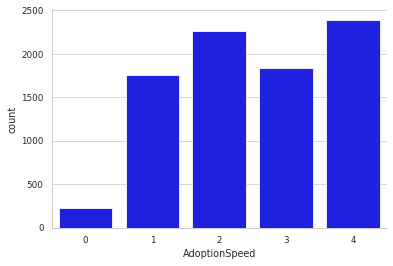

In [47]:
seaborn.countplot(dataset.AdoptionSpeed, color='blue')
seaborn.despine()

In [0]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

from tensorflow.keras import layers, models

In [0]:
# It's important to always use the same one-hot length
one_hot_columns = {
    one_hot_col: dataset[one_hot_col].max()   # Comienzan en 1
    for one_hot_col in ['Type', 'Gender', 'Color1', 'Vaccinated', 'MaturitySize', 'Sterilized', 'Health', 'FurLength']
}
embedded_columns = {
    embedded_col: dataset[embedded_col].max() + 1  # Breed comienza en 0
    for embedded_col in ['Breed1']
}
numeric_columns = ['Age', 'Fee']

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [0]:
def process_features(df):
    direct_features = []
    # Create one hot encodings
    for one_hot_col, max_value in one_hot_columns.items():
        direct_features.append(tf.keras.utils.to_categorical(df[one_hot_col] - 1, max_value))
        
    # Create and append numeric columns
    # Don't forget to normalize!
    scaler.fit(df[numeric_columns])
    numeric_col = scaler.transform(df[numeric_columns])
    
    # Concatenate all features that don't need further embedding into a single matrix.
    features = {'direct_features': numpy.hstack(direct_features), 'numeric_columns': numeric_col}
    # print(features)
    
    # Create embedding columns - nothing to do here. We will use the zero embedding for OOV
    for embedded_col in embedded_columns.keys():
        features[embedded_col] = df[embedded_col].values

    # Convert labels to one-hot encodings
    targets = tf.keras.utils.to_categorical(df[target_col], nlabels)
    
    return features, targets

In [0]:
X_train, y_train = process_features(dataset)

In [53]:
direct_features_input_shape = (X_train['direct_features'].shape[1],)
numeric_col_input_shape = (X_train['numeric_columns'].shape[1],)
direct_features_input_shape, numeric_col_input_shape

((28,), (2,))

In [0]:
batch_size = 32
# TODO shuffle the train dataset!
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices(
    process_features(dev_dataset)).batch(batch_size)

## Ejercicio 1

En una primera instancia se prueban dos redes, una más simple y otra más compleja, para ver como varía la métrica de accuracy sobre los conjuntos de entrenamiento y development. Se exploran distintos hiperparámetros:
* Cantidad de capas y número de neuronas.
* Funciones de activación
* Regularización de pesos, l1 l2 elastic net
* Dropout
* Batch normalization

__Primera red, simple:__
* Las neuronas de entrada son: 28 de direct features, 2 de numeric col y 77 de la salida de la capa de embedding
* Una capa oculta de 50 neuronas, con activación relu, regularización l2
* La capa de salida con 5 neuronas y softmax para clasificación

In [55]:
tf.keras.backend.clear_session()
from keras import regularizers

hidden_layer_size = 50   # numero de neuronas en dicha capa

# Add one input and one embedding for each embedded column
embedding_layers = []
inputs = []
for embedded_col, max_value in embedded_columns.items():
    input_layer = layers.Input(shape=(1,), name=embedded_col)
    inputs.append(input_layer)
    
    # Define the embedding layer
    embedding_size = int(max_value / 4)
    embedding_layers.append(
        tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
    print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

# Add the direct features already calculated
direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
inputs.append(direct_features_input)

numeric_col_input = layers.Input(shape=numeric_col_input_shape, name='numeric_columns')
inputs.append(numeric_col_input)
    
# Concatenate everything together
features = layers.concatenate(embedding_layers + [direct_features_input] + [numeric_col_input])
print(features)

dense1 = layers.Dense(hidden_layer_size, activation='relu', kernel_initializer='RandomNormal', 
                      kernel_regularizer=regularizers.l2(0.001))(features)
output_layer = layers.Dense(nlabels, activation='softmax')(dense1)

model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Adding embedding of size 77 for layer Breed1
Tensor("concatenate/Identity:0", shape=(None, 107), dtype=float32)


In [56]:
mlflow.set_experiment('first_approach')

with mlflow.start_run(nested=True):
    # Log model hiperparameters first
    mlflow.log_param('hidden_layer_size', hidden_layer_size)
    mlflow.log_param('embedded_columns', embedded_columns)
    mlflow.log_param('one_hot_columns', one_hot_columns)
    mlflow.log_param('numerical_columns', numeric_columns) 
    
    # Train
    epochs = 10
    history = model.fit(train_ds, epochs=epochs)
    
    # Evaluate
    loss, accuracy = model.evaluate(test_ds)
    print("*** Test loss: {} - accuracy: {}".format(loss, accuracy))
    mlflow.log_metric('epochs', epochs)
    mlflow.log_metric('loss', loss)
    mlflow.log_metric('accuracy', accuracy)

Epoch 1/10
265/265 [==============================] - 2s 8ms/step - loss: 1.4608 - accuracy: 0.3205
Epoch 2/10
265/265 [==============================] - 1s 4ms/step - loss: 1.4079 - accuracy: 0.3607
Epoch 3/10
265/265 [==============================] - 1s 4ms/step - loss: 1.3963 - accuracy: 0.3739
Epoch 4/10
265/265 [==============================] - 1s 3ms/step - loss: 1.3891 - accuracy: 0.3785
Epoch 5/10
265/265 [==============================] - 1s 3ms/step - loss: 1.3829 - accuracy: 0.3855
Epoch 6/10
265/265 [==============================] - 1s 3ms/step - loss: 1.3774 - accuracy: 0.3913
Epoch 7/10
265/265 [==============================] - 1s 3ms/step - loss: 1.3726 - accuracy: 0.3947
Epoch 8/10
265/265 [==============================] - 1s 3ms/step - loss: 1.3682 - accuracy: 0.3969
Epoch 9/10
265/265 [==============================] - 1s 3ms/step - loss: 1.3643 - accuracy: 0.3985
Epoch 10/10
67/67 [==============================] - 0s 4ms/step - loss: 1.3750 - accuracy: 0.3873
*

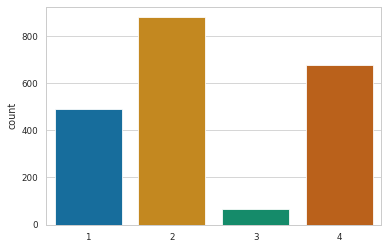

In [57]:
predictions = numpy.argmax(model.predict(test_ds), axis=1) # predicciones en dev
seaborn.countplot(predictions)

__Segunda red, más compleja:__
* Las neuronas de entrada son: 28 de direct features, 2 de numeric col y 77 de la salida de la capa de embedding
* Primer capa oculta con 60 neuronas, activación relu y regularización l2(0.001)
* Primer capa dropout con p=0.3 de tener una neurona apagada
* Segunda capa oculta con 15 neuronas, activación relu y regularización l2(0.001)
* Segunda capa dropout con p=0.3 de tener una neurona apagada
* La capa de salida con 5 neuronas y softmax para clasificación

Se intentó usar capas BatchNormalization pero en éste caso no tuvieron mejores resultados, ni una aceleración notable en el aprendizaje.

In [58]:
tf.keras.backend.clear_session()

hidden_layer_size = 60   # numero de neuronas en dicha capa
hidden_layer_size2 = 15

# Add one input and one embedding for each embedded column
embedding_layers = []
inputs = []
for embedded_col, max_value in embedded_columns.items():
    input_layer = layers.Input(shape=(1,), name=embedded_col)
    inputs.append(input_layer)
    
    # Define the embedding layer
    embedding_size = int(max_value / 4)
    embedding_layers.append(
        tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
    print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

# Add the direct features already calculated
direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
inputs.append(direct_features_input)

numeric_col_input = layers.Input(shape=numeric_col_input_shape, name='numeric_columns')
inputs.append(numeric_col_input)
    
# Concatenate everything together
features = layers.concatenate(embedding_layers + [direct_features_input] + [numeric_col_input])
print(features)

dense1 = layers.Dense(hidden_layer_size, activation='relu', kernel_initializer='RandomNormal', 
                      kernel_regularizer=regularizers.l2(0.001))(features)
dropout1 = layers.Dropout(0.3)(dense1)
dense2 = layers.Dense(hidden_layer_size2, activation='relu', kernel_initializer='RandomNormal', 
                      kernel_regularizer=regularizers.l2(0.001))(dropout1)
dropout2 = layers.Dropout(0.3)(dense2)
output_layer = layers.Dense(nlabels, activation='softmax')(dropout2)

model = models.Model(inputs=inputs, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Adding embedding of size 77 for layer Breed1
Tensor("concatenate/Identity:0", shape=(None, 107), dtype=float32)


In [59]:
mlflow.set_experiment('second_approach')

with mlflow.start_run(nested=True):
    # Log model hiperparameters first
    mlflow.log_param('hidden_layer_size', hidden_layer_size)
    mlflow.log_param('hidden_layer_size2', hidden_layer_size2)
    mlflow.log_param('embedded_columns', embedded_columns)
    mlflow.log_param('one_hot_columns', one_hot_columns)
    mlflow.log_param('numerical_columns', numeric_columns) 
    
    # Train
    epochs = 10
    history = model.fit(train_ds, epochs=epochs)
    
    # Evaluate
    loss, accuracy = model.evaluate(test_ds)
    print("*** Test loss: {} - accuracy: {}".format(loss, accuracy))
    mlflow.log_metric('epochs', epochs)
    mlflow.log_metric('loss', loss)
    mlflow.log_metric('accuracy', accuracy)

Epoch 1/10
265/265 [==============================] - 2s 9ms/step - loss: 1.5102 - accuracy: 0.2846
Epoch 2/10
265/265 [==============================] - 1s 4ms/step - loss: 1.4521 - accuracy: 0.3205
Epoch 3/10
265/265 [==============================] - 1s 4ms/step - loss: 1.4412 - accuracy: 0.3359
Epoch 4/10
265/265 [==============================] - 1s 4ms/step - loss: 1.4300 - accuracy: 0.3445
Epoch 5/10
265/265 [==============================] - 1s 4ms/step - loss: 1.4232 - accuracy: 0.3464
Epoch 6/10
265/265 [==============================] - 1s 4ms/step - loss: 1.4192 - accuracy: 0.3523
Epoch 7/10
265/265 [==============================] - 1s 4ms/step - loss: 1.4197 - accuracy: 0.3565
Epoch 8/10
265/265 [==============================] - 1s 4ms/step - loss: 1.4154 - accuracy: 0.3615
Epoch 9/10
265/265 [==============================] - 1s 4ms/step - loss: 1.4120 - accuracy: 0.3690
Epoch 10/10
67/67 [==============================] - 0s 4ms/step - loss: 1.3882 - accuracy: 0.3855
*

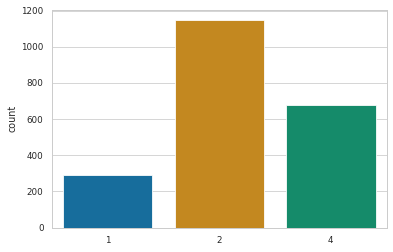

In [60]:
predictions = numpy.argmax(model.predict(test_ds), axis=1) # predicciones en dev
seaborn.countplot(predictions)

### __Conclusión:__

Primero tengamos en cuenta que para éste práctico no se esta usando el dataset completo, faltan las imágenes, y las descripciones entre otros datos. Por ello todos los accuracies son relativamente bajos.

Se exploran distintos modelos de red para ver como cambia la performance variando los distintos hiperparámetros.

La red mas compleja al tener dos capas ocultas y mas neuronas tiene más posibilidades de hacer overfitting, por lo que se decidió agregar capas dropout. Con ello se ve que baja el accuracy sobre el conjunto de entrenamiento pero se consigue un buen accuracy sobre test. Aun así la alta diferencia entre ambos accuracys hace sospechar sobre la estabilidad de la red y que el accuracy sobre dev solo haya sido casualidad.

Para la primera red, sin mayor regularización que l2(0.001) se obtiene buen accuracy tanto en train como en development.

Otras observaciones durante el proceso:
* Epochs: se observa que al aumentar el número de épocas por sobre 10, la red hace overfitting sobre el conjunto de entrenamiento y obtiene peor accuracy sobre el conjunto de development.
* Al aumentar la constante del regularizador de 0.001 a 0.01 la regularización de los pesos es más fuerte y disminuye tanto el accuracy de train como de development.
* El desempeño es mejor con relu en las capas ocultas que con tanh.

### Red usada para hacer submission en kaggle:
Por una cuestión de tiempo no se llegaron a probar las otras redes con el dataset de test de kaggle. Sí se probó la siguiente:

In [61]:
tf.keras.backend.clear_session()
from keras import regularizers

hidden_layer_size = 60   # numero de neuronas en dicha capa
hidden_layer_size2 = 15

# Add one input and one embedding for each embedded column
embedding_layers = []
inputs = []
for embedded_col, max_value in embedded_columns.items():
    input_layer = layers.Input(shape=(1,), name=embedded_col)
    inputs.append(input_layer)
    
    # Define the embedding layer
    embedding_size = int(max_value / 4)
    embedding_layers.append(
        tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
    print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

# Add the direct features already calculated
direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
inputs.append(direct_features_input)

numeric_col_input = layers.Input(shape=numeric_col_input_shape, name='numeric_columns')
inputs.append(numeric_col_input)
    
# Concatenate everything together
features = layers.concatenate(embedding_layers + [direct_features_input] + [numeric_col_input])
print(features)

dense1 = layers.Dense(hidden_layer_size, activation='relu', kernel_initializer='RandomNormal', kernel_regularizer=regularizers.l2(0.001),
                activity_regularizer=regularizers.l2(0.001))(features)
dense2 = layers.Dense(hidden_layer_size2, activation='relu', kernel_initializer='RandomNormal', kernel_regularizer=regularizers.l2(0.001),
                activity_regularizer=regularizers.l2(0.001))(dense1)
output_layer = layers.Dense(nlabels, activation='softmax')(dense2)

model = models.Model(inputs=inputs, outputs=output_layer)

Adding embedding of size 77 for layer Breed1
Tensor("concatenate/Identity:0", shape=(None, 107), dtype=float32)


In [62]:
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 77)        23716       Breed1[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_Squeeze (TensorFlow [(None, 77)]         0           embedding[0][0]                  
__________________________________________________________________________________________________
direct_features (InputLayer)    [(None, 28)]         0                                            
______________________________________________________________________________________________

In [63]:
mlflow.set_experiment('kaggle_approach')

with mlflow.start_run(nested=True):
    # Log model hiperparameters first
    mlflow.log_param('hidden_layer_size', hidden_layer_size)
    mlflow.log_param('hidden_layer_size2', hidden_layer_size2)
    mlflow.log_param('embedded_columns', embedded_columns)
    mlflow.log_param('one_hot_columns', one_hot_columns)
    mlflow.log_param('numerical_columns', numeric_columns) 
    
    # Train
    epochs = 10
    history = model.fit(train_ds, epochs=epochs)
    
    # Evaluate
    loss, accuracy = model.evaluate(test_ds)
    print("*** Test loss: {} - accuracy: {}".format(loss, accuracy))
    mlflow.log_metric('epochs', epochs)
    mlflow.log_metric('loss', loss)
    mlflow.log_metric('accuracy', accuracy)

Epoch 1/10
265/265 [==============================] - 2s 9ms/step - loss: 1.4740 - accuracy: 0.3133
Epoch 2/10
265/265 [==============================] - 1s 4ms/step - loss: 1.4228 - accuracy: 0.3511
Epoch 3/10
265/265 [==============================] - 1s 4ms/step - loss: 1.4107 - accuracy: 0.3673
Epoch 4/10
265/265 [==============================] - 1s 4ms/step - loss: 1.4031 - accuracy: 0.3727
Epoch 5/10
265/265 [==============================] - 1s 4ms/step - loss: 1.3973 - accuracy: 0.3794
Epoch 6/10
265/265 [==============================] - 1s 4ms/step - loss: 1.3924 - accuracy: 0.3850
Epoch 7/10
265/265 [==============================] - 1s 4ms/step - loss: 1.3877 - accuracy: 0.3903
Epoch 8/10
265/265 [==============================] - 1s 4ms/step - loss: 1.3835 - accuracy: 0.3946
Epoch 9/10
265/265 [==============================] - 1s 4ms/step - loss: 1.3793 - accuracy: 0.3965
Epoch 10/10
67/67 [==============================] - 0s 4ms/step - loss: 1.3818 - accuracy: 0.3855
*

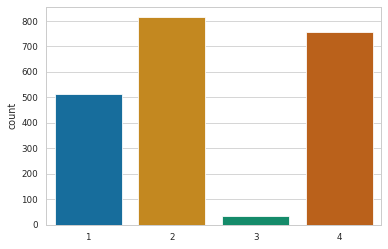

In [64]:
predictions = numpy.argmax(model.predict(test_ds), axis=1) # predicciones en dev
seaborn.countplot(predictions)

__Para hacer la submission a kaggle:__

In [65]:
testdir= '/content/drive/My Drive/DeepLearning/petfinder data/test.csv'
test_dataset = pandas.read_csv(os.path.join(testdir))
test_dataset[:3]

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,Description,PID
0,2,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,I just found it alone yesterday near my apartm...,1
1,1,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,Their pregnant mother was dumped by her irresp...,2
2,1,0,307,0,2,1,2,7,2,1,2,2,2,1,6,0,41326,Siu Pak just give birth on 13/6/10 to 6puppies...,7


In [0]:
def process_features_test(df):
    direct_features = []
    # Create one hot encodings
    for one_hot_col, max_value in one_hot_columns.items():
        direct_features.append(tf.keras.utils.to_categorical(df[one_hot_col] - 1, max_value))
        # crea los one-hot vector para cada var categórica y concatena un one-hot atras de otro en listas distintas

    # Create and append numeric columns. Don't forget to normalize!
    scaler.fit(df[numeric_columns])
    numeric_col = scaler.transform(df[numeric_columns]) # quedan las dos columnas normalizadas
    
    # Concatenate all features that don't need further embedding into a single matrix.
    features = {'direct_features': numpy.hstack(direct_features), 'numeric_columns': numeric_col}
    # np.hstack: Apila las matrices en secuencia horizontalmente (en sentido de columna). concatena los one-hot para cada registro

    # Create embedding columns - nothing to do here. We will use the zero embedding for OOV
    for embedded_col in embedded_columns.keys():
        features[embedded_col] = df[embedded_col].values 
        # para la entrada a la capa de embedding uso el valor de breed
    
    return features

In [67]:
test_data = tf.data.Dataset.from_tensor_slices(process_features_test(test_dataset)).batch(batch_size)

pred = model.predict(test_data)
pred

array([[0.02892626, 0.3229487 , 0.2790834 , 0.14472434, 0.22431724],
       [0.02936787, 0.32217154, 0.36372185, 0.19887048, 0.08586817],
       [0.01605583, 0.23956312, 0.37894672, 0.2388171 , 0.12661733],
       ...,
       [0.07549781, 0.4211816 , 0.25328407, 0.17600499, 0.07403149],
       [0.01086385, 0.07148602, 0.12640797, 0.1663283 , 0.62491393],
       [0.03760892, 0.36087874, 0.24062654, 0.14199367, 0.21889222]],
      dtype=float32)

In [0]:
# Se usan las probabilidades obtenidas para cada predicción para obtener la categoría predicha
ypred = numpy.argmax(pred, axis=1)

In [0]:
# subimos un dataframe con el pid de test y las predicciones de AdoptionSpeed: yy
submission = pandas.DataFrame(data= list(zip(test_dataset.PID, ypred)), columns=["PID", "AdoptionSpeed"])

submission.to_csv("./submission.csv", header=True, index=False)

In [70]:
submission.shape

(4411, 2)

## Ejercicio 2

Tomando una de las redes anteriores, vemos como varía la performance de la clasificación a medida que sacamos o agregamos columnas del dataset.

Dado que antes agregamos mucha info de los datos a la red, ahora vemos que sucede cuando incluimos menos información.

In [0]:
# It's important to always use the same one-hot length
one_hot_columns = {
    one_hot_col: dataset[one_hot_col].max()   # Comienzan en 1
    for one_hot_col in ['Type', 'Gender', 'Color1']
}
embedded_columns = {
    embedded_col: dataset[embedded_col].max() + 1  # Breed comienza en 0
    for embedded_col in ['Breed1']
}
numeric_columns = ['Age']

In [72]:
X_train, y_train = process_features(dataset)

direct_features_input_shape = (X_train['direct_features'].shape[1],)
numeric_col_input_shape = (X_train['numeric_columns'].shape[1],)
direct_features_input_shape, numeric_col_input_shape

((12,), (1,))

In [0]:
batch_size = 32
# TODO shuffle the train dataset!
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices(
    process_features(dev_dataset)).batch(batch_size)

In [74]:
tf.keras.backend.clear_session()

hidden_layer_size = 50   # numero de neuronas en dicha capa

# Add one input and one embedding for each embedded column
embedding_layers = []
inputs = []
for embedded_col, max_value in embedded_columns.items():
    input_layer = layers.Input(shape=(1,), name=embedded_col)
    inputs.append(input_layer)
    
    # Define the embedding layer
    embedding_size = int(max_value / 4)
    embedding_layers.append(
        tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
    print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

# Add the direct features already calculated
direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
inputs.append(direct_features_input)

numeric_col_input = layers.Input(shape=numeric_col_input_shape, name='numeric_columns')
inputs.append(numeric_col_input)
    
# Concatenate everything together
features = layers.concatenate(embedding_layers + [direct_features_input] + [numeric_col_input])
print(features)

dense1 = layers.Dense(hidden_layer_size, activation='relu', kernel_initializer='RandomNormal', 
                      kernel_regularizer=regularizers.l2(0.001))(features)
output_layer = layers.Dense(nlabels, activation='softmax')(dense1)

model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Adding embedding of size 77 for layer Breed1
Tensor("concatenate/Identity:0", shape=(None, 90), dtype=float32)


In [75]:
mlflow.set_experiment('first_approach')

with mlflow.start_run(nested=True):
    # Log model hiperparameters first
    mlflow.log_param('hidden_layer_size', hidden_layer_size)
    mlflow.log_param('embedded_columns', embedded_columns)
    mlflow.log_param('one_hot_columns', one_hot_columns)
    mlflow.log_param('numerical_columns', numeric_columns) 
    
    # Train
    epochs = 10
    history = model.fit(train_ds, epochs=epochs)
    
    # Evaluate
    loss, accuracy = model.evaluate(test_ds)
    print("*** Test loss: {} - accuracy: {}".format(loss, accuracy))
    mlflow.log_metric('epochs', epochs)
    mlflow.log_metric('loss', loss)
    mlflow.log_metric('accuracy', accuracy)

Epoch 1/10
265/265 [==============================] - 2s 8ms/step - loss: 1.4802 - accuracy: 0.3074
Epoch 2/10
265/265 [==============================] - 1s 4ms/step - loss: 1.4286 - accuracy: 0.3395
Epoch 3/10
265/265 [==============================] - 1s 3ms/step - loss: 1.4151 - accuracy: 0.3499
Epoch 4/10
265/265 [==============================] - 1s 3ms/step - loss: 1.4061 - accuracy: 0.3621
Epoch 5/10
265/265 [==============================] - 1s 3ms/step - loss: 1.3992 - accuracy: 0.3673
Epoch 6/10
265/265 [==============================] - 1s 3ms/step - loss: 1.3937 - accuracy: 0.3718
Epoch 7/10
265/265 [==============================] - 1s 3ms/step - loss: 1.3892 - accuracy: 0.3753
Epoch 8/10
265/265 [==============================] - 1s 3ms/step - loss: 1.3852 - accuracy: 0.3781
Epoch 9/10
265/265 [==============================] - 1s 3ms/step - loss: 1.3819 - accuracy: 0.3791
Epoch 10/10
67/67 [==============================] - 0s 4ms/step - loss: 1.3901 - accuracy: 0.3760
*

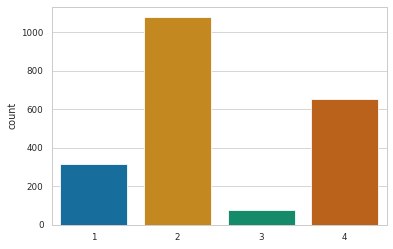

In [76]:
predictions = numpy.argmax(model.predict(test_ds), axis=1) # predicciones en dev
seaborn.countplot(predictions)

### __Conclusión:__

Se observa que al incluir menos datos en la misma red, la accuracy alcanzada en la clasificación es mucho menor tanto para los conjuntos de train como de development.

La búsqueda de hiperparámetros con toda la información disponible se realizó en el punto anterior.

Otra observación es que al no usar una semilla en train_test_split varían los conjuntos de train y dev en cada corrida. Con ello los valores de accuracy de las redes también varían notablemente, lo que hace pensar que no son configuraciones muy estables las usadas. Aún así han servido como experiencia para el experimento.